In [1]:
#Integrantes:
#Paul Vega Uribe
#Carlos Guizado Diaz
#Esteban Vilca Zuñiga
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import confusion_matrix
import os
import pickle
import seaborn as sn
import pandas as pd

In [2]:
class DescriptoresK(object):
    DatosEtiquetas = []
    DescriptoresBarba = []
    DescriptoresOjos = []
    DescriptoresPelo = []
    DescriptoresCara = []
    XBarba = np.zeros((len(DatosEtiquetas),0))
    XOjos = np.zeros((len(DatosEtiquetas),0))
    XPelo = np.zeros((len(DatosEtiquetas),0))
    XCara = np.zeros((len(DatosEtiquetas),0))
    DatosEtiquetasTest = []
    DescriptoresBarbaTest = []
    DescriptoresOjosTest = []
    DescriptoresPeloTest = []
    DescriptoresCaraTest = []
    XBarbaTest = np.zeros((len(DatosEtiquetasTest),0))
    XOjosTest = np.zeros((len(DatosEtiquetasTest),0))
    XPeloTest = np.zeros((len(DatosEtiquetasTest),0))
    XCaraTest = np.zeros((len(DatosEtiquetasTest),0))
    
    def loadImage(self,ruta, color=True):
        #print (ruta)
        ruta = "Imagenes/"+ruta
        img = cv2.imread(ruta)
        if (color):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img
    def showImage(self, img):
        if(img.ndim==2):
            plot_img=cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            plot_img=img
        plt.imshow(plot_img);
        plt.axis('off');
        plt.show()
        
    def Separador(self,img_aux):
        img=self.loadImage(img_aux)
        imgBarba = np.copy(img)
        imgOjos = np.copy(img)

        imgPelo = np.copy(img)
        imgCara = np.copy(img)

        imVal = False
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(img, 1.1, 5) #En caso de haber mas de un rostro en la imagen, lo detectar
        #showImage(img)
        #print(faces)
        if(len(faces) != 0):
            if(faces[0][3] < 100.0):
                imVal = True
            else:
                imVal = False
        if(len(faces) == 0 or imVal):
            _x=img.shape[0]
            _y=img.shape[1]
            #imgPelo=imgPelo[_x-int(_x-_x/2.3):_x,_y-int(_y/5):_y+int(_y+_y/5)]
            imgBarba=imgBarba[_x-int(_x/3):_x-int(_x/20),0:_y]
            imgOjos=imgOjos[_x-int(_x/1.5):_x-int(_x/2.3),0:_y-int(_y/15)]
            imgPelo=imgPelo[0:int(_x/5),0:_y]
            imgCara=imgCara[0:_x,0:_y]
            #showImage(imgBarba)
            #showImage(imgOjos)
            #showImage(imgPelo)
            #showImage(imgCara)
        else:
            for (x,y,ancho,alto) in faces: #Podemos recortar las imagenes con estos valores: img = img[y:z+ancho,y:x+alto]
                cv2.rectangle(img,(x,y),(x+ancho,y+alto),(255,0,0),2)
                #showImage(img)
                if(int(y+alto/1.5)>=0):
                    i = int(y+alto/1.5)
                else:
                    i = 0
                if(int(x+ancho+ancho/4)<=img.shape[0]):
                    I = int(x+ancho+ancho/4)
                else:
                    I = img.shape[0]
            
                imgBarba=imgBarba[i:I,x:y+ancho]
            
                if(int(x+ancho/4)>=0):
                    i = int(x+ancho/4)
                else:
                    i = 0
                if(int(y+ancho/2)<=img.shape[0]):
                    I = int(y+ancho/2)
                else:
                    I = img.shape[0]
                
                imgOjos=imgOjos[i:I,x:y+alto]
            
                if(x-int(alto-alto/2.3)>=0):
                    i = x-int(alto-alto/2.3)
                else:
                    i = 0
                if(y<=img.shape[0]):
                    I = y
                else:
                    I = img.shape[0]
                
                imgPelo=imgPelo[i:I,y-int(ancho/5):y+int(alto+alto/5)]
                imgCara=imgCara[y:y+ancho,x:x+alto]
                #showImage(imgBarba)
                #showImage(imgOjos)
                #showImage(imgPelo)
                #showImage(imgCara)
        return imgBarba,imgOjos,imgPelo,imgCara

    def FeaturesExt(self, img,mode):
        step_size=2
        kp1= [cv2.KeyPoint(x, y, step_size) for y in range(0, img.shape[0], step_size) 
                                           for x in range(0, img.shape[1], step_size)]
        if mode.lower() == 'sift':
            sift = cv2.xfeatures2d.SIFT_create()
            kp,des = sift.compute(img,kp1)
        if mode.lower() == 'surf':
            surf = cv2.xfeatures2d.SURF_create()
            kp,des = surf.compute(img,kp1)
        if mode.lower() == 'orb':
            orb = cv2.ORB_create()
            kp,des = orb.compute(img,kp1)
        #self.showImage(img)
        outImg=np.copy(img)
        cv2.drawKeypoints(img,kp,outImg)
        return kp,des,outImg

    def DesPCA(self, des,dim):
        des2=PCA(dim).fit_transform(des)
        return des2
    def Wew(self, img,featex,pca):
        kp,des,img=self.FeaturesExt(img,featex)
        if pca>0:
            des=self.DesPCA(des,pca)
        return kp,des,img
    
    def __init__(self):
        print("Iniciando...")
        self.DatosEtiquetas = []
        self.DescriptoresBarba = []
        self.DescriptoresOjos = []
        self.DescriptoresPelo = []
        self.DescriptoresCara = []
        self.DatosEtiquetasTest = []
        self.DescriptoresBarbaTest = []
        self.DescriptoresOjosTest = []
        self.DescriptoresPeloTest = []
        self.DescriptoresCaraTest = []
        f = open('Etiquetas.csv')
        f.readline() #Desconsideramos la cabecera
        for idx, linea in enumerate(f):
            self.DatosEtiquetas.append(linea.rstrip().split(';'))
        f.close()
        f = open('Etiquetas_Test.csv')
        f.readline() #Desconsideramos la cabecera
        for idx, linea in enumerate(f):
            self.DatosEtiquetasTest.append(linea.rstrip().split(';'))
        f.close()
        
    def obtenerDescriptores(self,modoDeObtencionKP,PCAdelModo):
        print('Obteniendo Descripciones')
        for elemento in self.DatosEtiquetas:
            #print(elemento[0])
            imgBarba,imgOjos,imgPelo,imgCara = self.Separador((elemento[0]))
            #if imgBarba.size == 0 or imgOjos.size == 0 or imgPelo.size == 0 or imgCara.size == 0:
            #    continue
            keyp,descrip,fimg=self.Wew(imgBarba,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresBarba.append(descrip)
            keyp,descrip,fimg=self.Wew(imgOjos,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresOjos.append(descrip)
            keyp,descrip,fimg=self.Wew(imgPelo,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresPelo.append(descrip)
            keyp,descrip,fimg=self.Wew(imgCara,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresCara.append(descrip)
        for elemento in self.DatosEtiquetasTest:
            #print(elemento[0])
            imgBarba,imgOjos,imgPelo,imgCara = self.Separador((elemento[0]))
            #if imgBarba.size == 0 or imgOjos.size == 0 or imgPelo.size == 0 or imgCara.size == 0:
            #    continue
            keyp,descrip,fimg=self.Wew(imgBarba,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresBarbaTest.append(descrip)
            keyp,descrip,fimg=self.Wew(imgOjos,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresOjosTest.append(descrip)
            keyp,descrip,fimg=self.Wew(imgPelo,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresPeloTest.append(descrip)
            keyp,descrip,fimg=self.Wew(imgCara,modoDeObtencionKP,PCAdelModo)
            self.DescriptoresCaraTest.append(descrip)
            #showImage(fimg)
            #break
        print('Descripciones Obtenidas')
    def obtenerdescriptoresK(self,nK=10,nK2=None,nK3=None,nK4=None,nK5=None):
        if nK2 is None:
            nK2=nK
        if nK3 is None:
            nK3=nK
        if nK4 is None:
            nK4=nK
        if nK5 is None:
            nK5=nK
    
        print('Iniciando K-Means.')
        print('K-Means para Barba...')
        self.KmeansBarba = KMeans(nK)
        self.XBarba = np.zeros((len(self.DatosEtiquetas),nK))
        _DescriptoresBarba=np.empty((0,len(self.DescriptoresBarba[0][1])))
        for idx, linea in enumerate(self.DatosEtiquetas):
            _DescriptoresBarba=np.vstack((_DescriptoresBarba,self.DescriptoresBarba[idx]))
        self.KmeansBarba.fit(_DescriptoresBarba)
        
        print('K-Means para Ojos...')
        self.KmeansOjos = KMeans(nK2)
        self.XOjos = np.zeros((len(self.DatosEtiquetas),nK2))
        _DescriptoresOjos=np.empty((0,len(self.DescriptoresOjos[0][1])))
        for idx, linea in enumerate(self.DatosEtiquetas):
            #print(self.DatosEtiquetas[idx])
            _DescriptoresOjos=np.vstack((_DescriptoresOjos,self.DescriptoresOjos[idx]))
        self.KmeansOjos.fit(_DescriptoresOjos)
        
#32 para sift
        print('K-Means para Pelo...')
        self.KmeansPelo = KMeans(nK3)
        self.XPelo= np.zeros((len(self.DatosEtiquetas),nK3))
        _DescriptoresPelo=np.empty((0,len(self.DescriptoresPelo[0][1])))
        for idx, linea in enumerate(self.DatosEtiquetas):
            _DescriptoresPelo=np.vstack((_DescriptoresPelo,self.DescriptoresPelo[idx]))
        self.KmeansPelo.fit(_DescriptoresPelo)
        
        print('K-Means para Cara...')
        self.KmeansCara = KMeans(nK4)
        self.XCara = np.zeros((len(self.DatosEtiquetas),nK4))
        _DescriptoresCara=np.empty((0,len(self.DescriptoresCara[0][1])))
        for idx, linea in enumerate(self.DatosEtiquetas):
            _DescriptoresCara=np.vstack((_DescriptoresCara,self.DescriptoresCara[idx]))
        self.KmeansCara.fit(_DescriptoresCara)
        print("K-Means Finalizado.")
        
        print("Obteniendo histogramas de entrenamiento.")
        for idx, linea in enumerate(self.DatosEtiquetas):
            for descriptor in self.DescriptoresBarba[idx]:      
                self.XBarba[idx][self.KmeansBarba.predict([descriptor])]+=1
                self.XOjos[idx][self.KmeansOjos.predict([descriptor])]+=1
                self.XPelo[idx][self.KmeansPelo.predict([descriptor])]+=1
                self.XCara[idx][self.KmeansCara.predict([descriptor])]+=1              
        print("Histogramas obtenidos.")
        
        #print(self.XBarba)
        #print(self.XOjos)
        #print(self.XPelo)
        #print(self.XCara)

        
    def Entrenar(self,
                 mode1='svm',ker1='rbf',gamma_op1=8,
                 mode2=None,ker2=None,gamma_op2=None,
                 mode3=None,ker3=None,gamma_op3=None,
                 mode4=None,ker4=None,gamma_op4=None,
                 mode5=None,ker5=None,gamma_op5=None):
        
        if mode2 is None:
            mode2=mode1
            ker2 = ker1
            gamma_op2 = gamma_op1
        if mode3 is None:
            mode3=mode1
            ker3 = ker1
            gamma_op3 = gamma_op1
        if mode4 is None:
            mode4=mode1
            ker4 = ker1
            gamma_op4 = gamma_op1
        if mode5 is None:
            mode5=mode1
            ker5 = ker1
            gamma_op5 = gamma_op1
            
        print('Empezando entrenamiento.')
        Data = np.array(self.DatosEtiquetas)
        #Barba
        print('Entrenando clasificador barba...')
        if mode1.lower() == 'svm':
            if ker1 in ["linear", "sigmoid", "poly", "rbf"]:
                self.clfBarba = svm.SVC(kernel=ker1, gamma=gamma_op1)    
                self.clfBarba.fit(self.XBarba,Data[:,1])
        #Calvo
        print('Entrenando clasificador calvo...')
        if mode2.lower() == 'svm':
            if ker2 in ["linear", "sigmoid", "poly", "rbf"]:
                self.clfCalvo = svm.SVC(kernel=ker2, gamma=gamma_op2)    
                self.clfCalvo.fit(self.XPelo,Data[:,2])
        #Hombre
        print('Entrenando clasificador hombre...')
        if mode3.lower() == 'svm':
            if ker3 in ["linear", "sigmoid", "poly", "rbf"]:
                self.clfHombre = svm.SVC(kernel=ker3, gamma=gamma_op3)    
                self.clfHombre.fit(self.XCara,Data[:,3])
        #Lentes
        print('Entrenando clasificador lentes...')
        if mode4.lower() == 'svm':
            if ker4 in ["linear", "sigmoid", "poly", "rbf"]:
                self.clfLentes = svm.SVC(kernel=ker4, gamma=gamma_op4)    
                self.clfLentes.fit(self.XOjos,Data[:,4])
        #Rubio
        print('Entrenando clasificador rubio...')
        if mode5.lower() == 'svm':
            if ker5 in ["linear", "sigmoid", "poly", "rbf"]:
                self.clfRubio = svm.SVC(kernel=ker5, gamma=gamma_op5)    
                self.clfRubio.fit(self.XPelo,Data[:,5])
        
        print('Entrenamiento finalizado.')
            
            
    def GetXTest(self):
        print('Obteniendo histograma de prueba.')
        self.XBarbaTest = np.zeros((len(self.DatosEtiquetasTest),self.KmeansBarba.get_params().get('n_clusters')))
        self.XOjosTest = np.zeros((len(self.DatosEtiquetasTest),self.KmeansOjos.get_params().get('n_clusters')))
        self.XPeloTest = np.zeros((len(self.DatosEtiquetasTest),self.KmeansPelo.get_params().get('n_clusters')))
        self.XCaraTest = np.zeros((len(self.DatosEtiquetasTest),self.KmeansCara.get_params().get('n_clusters')))
        for idx, linea in enumerate(self.DatosEtiquetasTest):
            for descriptor in self.DescriptoresBarbaTest[idx]:      
                self.XBarbaTest[idx][self.KmeansBarba.predict([descriptor])]+=1
                self.XOjosTest[idx][self.KmeansOjos.predict([descriptor])]+=1
                self.XPeloTest[idx][self.KmeansPelo.predict([descriptor])]+=1
                self.XCaraTest[idx][self.KmeansCara.predict([descriptor])]+=1
        print('Histogramas obtenidos')
                
    def Predecir(self):
        print('Prediciendo etiquetas...')
        self.ZPredBarba = self.clfBarba.predict(self.XBarbaTest)
        self.ZPredCalvo = self.clfCalvo.predict(self.XPeloTest)
        self.ZPredHombre = self.clfHombre.predict(self.XCaraTest)
        self.ZPredLentes = self.clfLentes.predict(self.XOjosTest)
        self.ZPredRubio = self.clfRubio.predict(self.XPeloTest)
        print('Etiquetas predecidas.')
  
    def MatricesConfusion(self):
        print('Generando matrices de confusion...')
        Data = np.array(self.DatosEtiquetasTest)
        self.cmBarba = confusion_matrix(Data[:,1], self.ZPredBarba)
        self.cmCalvo = confusion_matrix(Data[:,2], self.ZPredCalvo)
        self.cmHombre = confusion_matrix(Data[:,3], self.ZPredHombre)
        self.cmLentes = confusion_matrix(Data[:,4], self.ZPredLentes)
        self.cmRubio = confusion_matrix(Data[:,5], self.ZPredRubio)
        print('Matrices de confusion generadas.')
        
    def MostrarMatriz(self,clf='barba'):
        if clf.lower()=='barba':
            df_cm = pd.DataFrame(manejadorKP.cmBarba, range(manejadorKP.cmBarba.shape[0]),range(manejadorKP.cmBarba.shape[1]))
        if clf.lower()=='calvo':
            df_cm = pd.DataFrame(manejadorKP.cmCalvo, range(manejadorKP.cmCalvo.shape[0]),range(manejadorKP.cmCalvo.shape[1]))
        if clf.lower()=='hombre':
            df_cm = pd.DataFrame(manejadorKP.cmHombre, range(manejadorKP.cmHombre.shape[0]),range(manejadorKP.cmHombre.shape[1]))
        if clf.lower()=='lentes':
            df_cm = pd.DataFrame(manejadorKP.cmLentes, range(manejadorKP.cmLentes.shape[0]),range(manejadorKP.cmLentes.shape[1]))
        if clf.lower()=='rubio':
            df_cm = pd.DataFrame(manejadorKP.cmRubio, range(manejadorKP.cmRubio.shape[0]),range(manejadorKP.cmRubio.shape[1]))
        sn.set(font_scale=1.4)
        sn.heatmap(df_cm, annot=True,cmap='Blues',annot_kws={"size": 16})
        plt.ylabel('Verdadero')
        plt.xlabel('Prediccion')
        plt.show()
        
    def Guardar(self):
        directory = 'TF Pruebas'
        if not os.path.exists(directory):
            os.makedirs(directory)
        n=len(os.listdir(directory))+1
        output=open(directory+'//Prueba'+str(n)+'.pkl', 'wb')
        pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
        
    def Cargar(self,n):
        directory = 'TF Pruebas'
        if not os.path.exists(directory):
            os.makedirs(directory)
        _input=open(directory+'//Prueba'+str(n)+'.pkl', 'rb')
        _objeto=pickle.load(_input)
        self.DatosEtiquetas = _objeto.DatosEtiquetas
        self.DescriptoresBarba = _objeto.DescriptoresBarba
        self.DescriptoresOjos = _objeto.DescriptoresOjos
        self.DescriptoresPelo = _objeto.DescriptoresPelo
        self.DescriptoresCara = _objeto.DescriptoresCara
        self.DatosEtiquetasTest = _objeto.DatosEtiquetasTest
        self.DescriptoresBarbaTest = _objeto.DescriptoresBarbaTest
        self.DescriptoresOjosTest = _objeto.DescriptoresOjosTest
        self.DescriptoresPeloTest = _objeto.DescriptoresPeloTest
        self.DescriptoresCaraTest = _objeto.DescriptoresCaraTest
        self.XBarba = _objeto.XBarba
        self.XOjos = _objeto.XOjos
        self.XPelo = _objeto.XPelo
        self.XCara = _objeto.XCara
        self.XBarbaTest = _objeto.XBarbaTest
        self.XOjosTest = _objeto.XOjosTest
        self.XPeloTest = _objeto.XPeloTest
        self.XCaraTest = _objeto.XCaraTest
        self.KmeansBarba = _objeto.KmeansBarba
        self.KmeansOjos = _objeto.KmeansOjos
        self.KmeansPelo = _objeto.KmeansPelo
        self.KmeansCara = _objeto.KmeansCara
        self.clfBarba = _objeto.clfBarba
        self.clfCalvo = _objeto.clfCalvo
        self.clfHombre = _objeto.clfHombre
        self.clfLentes = _objeto.clfLentes
        self.clfRubio = _objeto.clfRubio
        self.ZPredBarba = _objeto.ZPredBarba
        self.ZPredCalvo = _objeto.ZPredCalvo
        self.ZPredHombre = _objeto.ZPredHombre
        self.ZPredLentes = _objeto.ZPredLentes
        self.ZPredRubio = _objeto.ZPredRubio
        self.cmBarba = _objeto.cmBarba
        self.cmCalvo = _objeto.cmCalvo
        self.cmHombre = _objeto.cmHombre
        self.cmLentes = _objeto.cmLentes
        self.cmRubio = _objeto.cmRubio

#Aaron_Peirsol_0001

In [3]:
#Crea un nuevo objeto
manejadorKP = DescriptoresK()

Iniciando...


In [4]:
#Carga el objeto desde un archivo pickle
#Parametro: numero de archivo ej:1 = Prueba1.pkl
#manejadorKP.Cargar(1)

Obteniendo Descripciones
Descripciones Obtenidas
Iniciando K-Means.
K-Means para Barba...
K-Means para Ojos...
K-Means para Pelo...
K-Means para Cara...
K-Means Finalizado.
Obteniendo histogramas de entrenamiento.
Histogramas obtenidos.
Empezando entrenamiento.
Entrenando clasificador barba...
Entrenando clasificador calvo...
Entrenando clasificador hombre...
Entrenando clasificador lentes...
Entrenando clasificador rubio...
Entrenamiento finalizado.
Obteniendo histograma de prueba.
Histogramas obtenidos
Prediciendo etiquetas...
Etiquetas predecidas.
Generando matrices de confusion...
Matrices de confusion generadas.


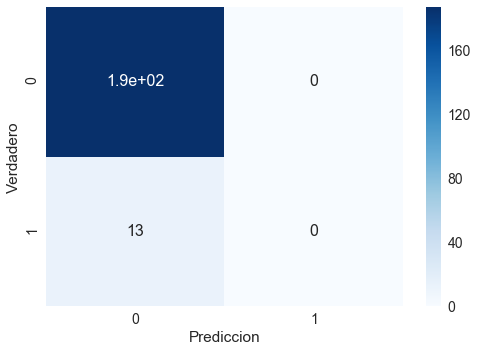

In [5]:
#Genera los descriptores y aplica PCA
#Primer parametro: sift,surf,orb
#Segundo: cantidad de dimensiones para PCA, si es 0 no se aplica PCA. Valores mayores a 40 puede causar error debido al tamaño
#de las imagenes recortadas
manejadorKP.obtenerDescriptores('surf',12)
#Genera los K-means para cada etiqueta y los histogramas para cada objeto
#Parametro: cantidad de ks
manejadorKP.obtenerdescriptoresK(8)
#Entrena el clasificador
manejadorKP.Entrenar('svm','rbf',8)
#Genera los histogramas de los datos de testeo
manejadorKP.GetXTest()
#Genera las etiquetas de los datos de testeo
manejadorKP.Predecir()
#Genera las matrices de confusion para todas las columnas
manejadorKP.MatricesConfusion()


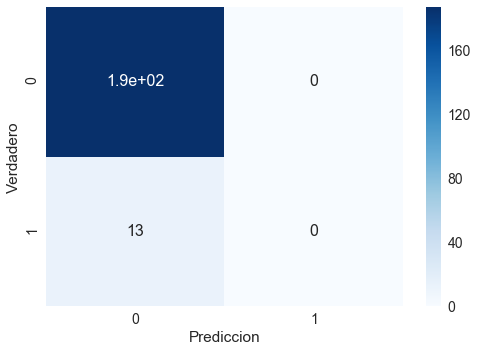

In [13]:
#Muestra la matriz de confusion
#Parametros: barba,calvo,hombre,lentes,rubio
manejadorKP.MostrarMatriz('barba')

In [12]:
#Guarda el objeto en un archivo pickle
#El archivo guarda todo el objeto, lo que incluye: etiquetas, clasificador, descriptores, k-means,etc
#El archivo es muy pesado asi que no se subira al git
manejadorKP.Guardar()